## Loading and Preparation

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import optuna
from torch.utils.data import DataLoader
from torchinfo import summary

from utils.training import train, optuna_train, best_torch_device
from utils.dataset import EEGDataset

/Users/muhanz/anaconda3/envs/147fn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

### Select Ideally GPU for Training

In [3]:
device = best_torch_device()
print(device)

mps


### Load Data

In [4]:
X_train = np.load('data/X_train_valid.npy')
y_train = np.load('data/y_train_valid.npy')
X_test = np.load('data/X_test.npy')
y_test = np.load('data/y_test.npy')

split_idx = 1777
X_train, X_valid = X_train[:split_idx], X_train[split_idx:]
y_train, y_valid = y_train[:split_idx], y_train[split_idx:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1777, 22, 1000)
y_train shape: (1777,)
X_valid shape: (338, 22, 1000)
y_valid shape: (338,)
X_test shape: (443, 22, 1000)
y_test shape: (443,)


In [5]:
train_set = EEGDataset(X_train, y_train, label_smoothing=False)
valid_set = EEGDataset(X_valid, y_valid, label_smoothing=False)
test_set = EEGDataset(X_test, y_test, label_smoothing=False)

In [6]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

## Vision Transformer Model

In [58]:
from models.Transformer import ViTforEEG

raw_model = ViTforEEG(input_dim=(22, 1000),
                      out_dim=4,
                      n_patches=500,
                      hidden_dims=64,
                      num_heads=8,
                      ff_dim=64,
                      dropout=0.5,
                      num_layers=2,
                      device='mps').to(device)

summary(raw_model)

Layer (type:depth-idx)                                            Param #
ViTforEEG                                                         32,128
├─Linear: 1-1                                                     2,880
├─TransformerEncoder: 1-2                                         --
│    └─ModuleList: 2-1                                            --
│    │    └─TransformerEncoderLayer: 3-1                          25,216
│    │    └─TransformerEncoderLayer: 3-2                          25,216
├─Sequential: 1-3                                                 --
│    └─Linear: 2-2                                                260
│    └─Softmax: 2-3                                               --
Total params: 85,700
Trainable params: 53,636
Non-trainable params: 32,064

In [59]:
optimizer = torch.optim.Adam(raw_model.parameters(), lr=0.0001, weight_decay=1e-03)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=raw_model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_func=nn.CrossEntropyLoss(),
    train_data=train_loader,
    val_data=valid_loader,
    early_stopping_patience=50,
    cp_path="models/transformer",
    cp_filename="raw.pt",
    n_epochs=300,
    show_progress_bar=False,
)

Using device: mps
[Epoch 0] val_acc=0.286982 train_acc=0.250422 val_loss=0.045134 train_loss=0.043857
Validation loss decreased (inf --> 0.045134).  Saving model ...
[Epoch 1] val_acc=0.263314 train_acc=0.266742 val_loss=0.045074 train_loss=0.043663
Validation loss decreased (0.045134 --> 0.045074).  Saving model ...
[Epoch 2] val_acc=0.266272 train_acc=0.267304 val_loss=0.045008 train_loss=0.043717
Validation loss decreased (0.045074 --> 0.045008).  Saving model ...
[Epoch 3] val_acc=0.272189 train_acc=0.267304 val_loss=0.044970 train_loss=0.043646
Validation loss decreased (0.045008 --> 0.044970).  Saving model ...
[Epoch 4] val_acc=0.281065 train_acc=0.278559 val_loss=0.044908 train_loss=0.043596
Validation loss decreased (0.044970 --> 0.044908).  Saving model ...
[Epoch 5] val_acc=0.281065 train_acc=0.276308 val_loss=0.044872 train_loss=0.043569
Validation loss decreased (0.044908 --> 0.044872).  Saving model ...
[Epoch 6] val_acc=0.301775 train_acc=0.293191 val_loss=0.044902 train

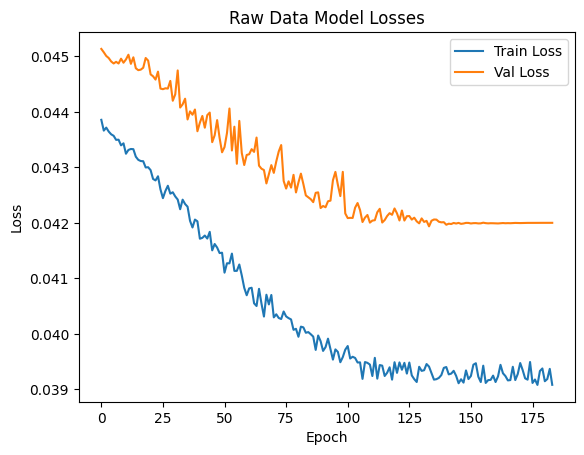

In [60]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Raw Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

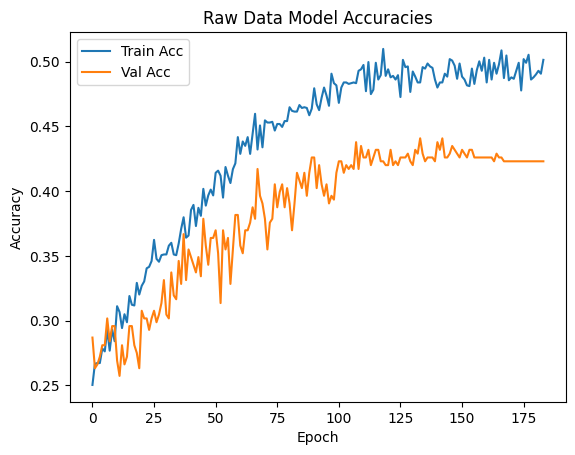

In [61]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Raw Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [62]:
# Load best model and test
best_model = torch.load("models/transformer/raw.pt")
best_model.to(device)
best_model.eval()

ViTforEEG(
  (lin_emb): Linear(in_features=44, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=64, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.5, inplace=False)
        (dropout2): Dropout(p=0.5, inplace=False)
      )
    )
  )
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=4, bias=True)
    (1): Softmax(dim=-1)
  )
)

In [63]:
# Evaluate on raw data
test_acc = 0
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = best_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_loader.dataset)
print("Train on raw data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on raw data, evaluate on raw data
Test Acc: 0.4312


## Model Experimentation

In [23]:
from models.Transformer import ViTforEEG 

new_model = ViTforEEG().to(device)

x = torch.randn(29, 22, 1000)
new_model(x).shape

torch.Size([29, 4])